一步一步写一个简单的技术指标策略
---

技术分析是股票投资中的主要方法之一，ricequant支持的talib库可以很方便的为开发者计算技术指标。

talib目前支持的指标列表：http://ta-lib.org/function.html

相信大家已经学会使用回测平台运行简单策略了。接下来我们一起挑战自我写一个技术指标策略吧。

在写策略之前，我们需要找到一个idea，不需要多么复杂高端，自圆其说即可。比如反转策略，逻辑虽然十分简单，有时也能有很好的回测结果。

我们这就随意的选择了一个看起来比较萌的技术指标：TR(波幅)

$$ TR_t = max(∣High_t-Low_t∣,∣High_t-Close_{t-1}∣,∣Close_{t-1}-Low_t∣)$$

难以直观理解数学公式在股市中的意义也没关系，根据百度的教导，我们知道TR描述的是股价的震荡幅度，在通常情况下，波幅会保持在一定常态下，但当有主力资金进出时，波幅变化会加剧，进入异常区间。

我们推断，当价格下跌十分剧烈时，受到羊群效应的影响，股价可能会进一步下跌一段时间，因此应该卖出持有的股票。这个逻辑是十分通顺的。那么根据这个设想，我们就确定了卖出条件。

那么买入什么股票呢？权重是多少呢？

在这里我们简单的选取每日选取中证500中市值最小的10只股票，按市值由小到大依次由大到小赋权，每个月第十个交易日更新中证500股票池，并在持仓股票昨日收盘价-前日收盘价 < -0.95倍的昨日TRANGE时卖出所持有的全部股票。

整个过程逻辑自洽，只等待我们将代码编写出来，用回测验证结果了。

按照已有思路，我们轻松的写出如下代码，并运行回测：

In [ ]:
import pandas as pd
import numpy as np
import time
import talib

# 获取过去30个交易日的fields = data_index的数据
def get_data(stock,data_index):
    # 获取过去30个交易日的fields = data_index的数据，并保存在res中
    res = history_bars(stock,30,'1d',data_index)
    # 将type(res) 转为 numpy.array格式
    res = np.array(res)
    # 返回res的值
    return res

# 生成保存下单权重的列表
def weight_decide(res):
    # 申明alist是一个列表 
    alist = []
    for i in range(len(res)):
    # 向alist中添加一个dict，key是股票名称，value是购买的比例，根据市值由小到大rank并由大到小赋权。
        alist.append({res[i] : (2*(len(res)-i))/((1+len(res))*len(res))})
    # 返回alist
    return alist

# 生成将要购买的股票池
def choose_stocks(context):
    # 选出context.stock_list中市值最小的10支股票
    market_cap = get_fundamentals(query(fundamentals.eod_derivative_indicator.market_cap).filter(fundamentals.stockcode.in_(context.stock_list)).order_by(fundamentals.eod_derivative_indicator.market_cap).limit(10))
    # 取出这些股票代码，并赋给context.chosen
    context.chosen = list(market_cap.columns)
    pass

# 获得中证500成分股股票列表
def get_stock_list(context,bar_dict):
    context.stock_list = index_components('中证500(深)')
    pass

def init(context):
    # 申明自定义全局变量 context.chosen
    context.chosen = []
    # 申明自定义全局变量 context.price_list
    context.price_list = pd.DataFrame() # 持仓股票的若干天收盘价
    # 申明自定义全局变量 context.stock_list
    context.stock_list = [] # 中证500 成分股股票池
    # 每月第10个交易日调用get_stock_list函数，更新中证500股票池。
    scheduler.run_monthly(get_stock_list,tradingday=10)
    pass

def before_trading(context):
    # 将中证500成分股赋给context.stock_list
    context.stock_list = index_components('中证500(深)')
    # 生成将要购买的股票池
    choose_stocks(context)
    # 时间戳转换，start_date(st)和end_date(ed) 
    ts = time.strptime(str(context.now),"%Y-%m-%d %H:%M:%S")
    st = int(time.mktime(ts)) - 24*3600*5
    st = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(st))
    ed = int(time.mktime(ts)) - 24*3600*1
    ed = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(ed))
    # 如果目前有持仓：
    if list(context.portfolio.positions.keys()):
    # 取出持仓股票在st至ed时间之间的收盘价，结果传入context.price_list
        context.price_list = get_price(list(context.portfolio.positions.keys()),start_date=st,end_date=ed,fields='close')
    pass

def handle_bar(context,bar_dict):
    # 遍历持仓股票
    for stock in list(context.portfolio.positions.keys()):
        # 获得近30个交易日的TRANGE技术指标，并转格式为pd.Series()
        res = pd.Series(talib.TRANGE(get_data(stock,'high'), get_data(stock,'low'), get_data(stock,'close')))
        try:
            # 若stock昨日收盘价-前日收盘价 < -0.95倍的昨日TRANGE
            if context.price_list[stock].iloc[-1] - context.price_list[stock].iloc[-2] < -0.95 * res.iloc[-2]:
            # 卖出所有持仓股票（目标仓位为0）    
                order_target_percent(stock,0)
        except:
            # 若stock不在context的列名中
            if stock not in context.price_list.columns:
            # 卖出所有持仓股票（目标仓位为0）  
                order_target_percent(stock,0)
    # 调用weight_decide函数，生成保存下单权重的列表，并将结果保存在alist中。
    alist = weight_decide(context.chosen)
    for stock in alist:
        # 按权重下单（目标仓位保存在weight_decide的value中）  
        order_target_percent(list(stock.keys())[0],list(stock.values())[0])
    pass

def after_trading(context):
    pass

我们选择2015-01-01 至 2017-02-27 的日级别数据作为回测事件，并选择中证500作为基准，回测结果如下：

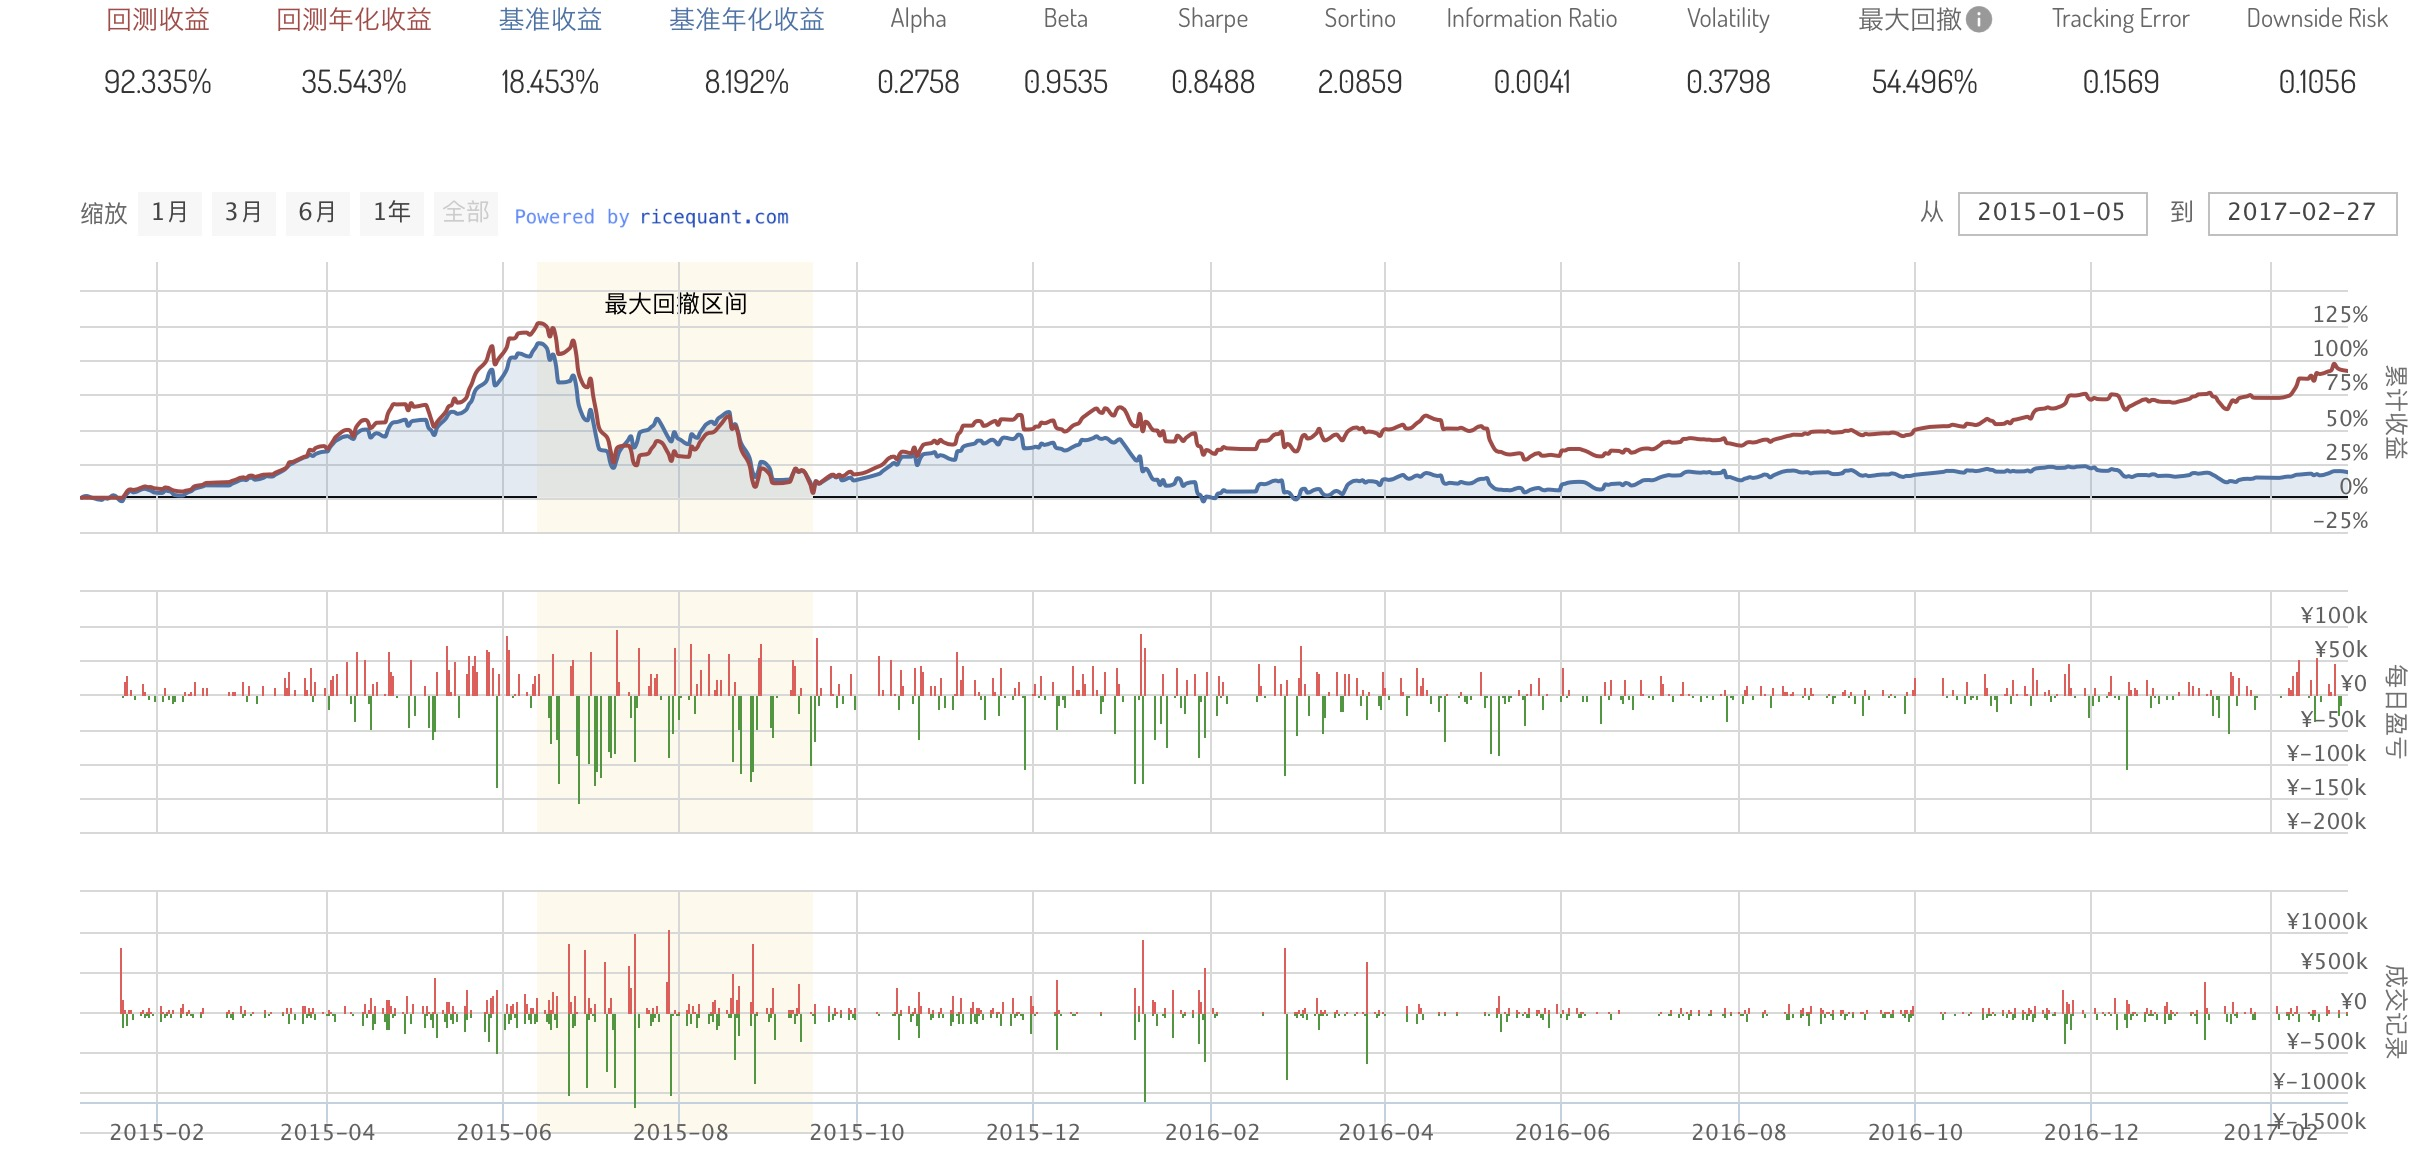

In [3]:
from IPython.display import display, Image
display(Image(filename='test_result.jpeg'))

介绍日回测和分钟级回测
---

ricequant 除提供日频率的回测外，为满足用户更多可能的需求，还提供更精确的分钟级别回测。

用户进入回测平台后，右侧可以调节回测时间段，账户初始金额，回测频率可选每日／每分钟，在更多中还可以更换基准策略和撮合机制，设置滑点等。

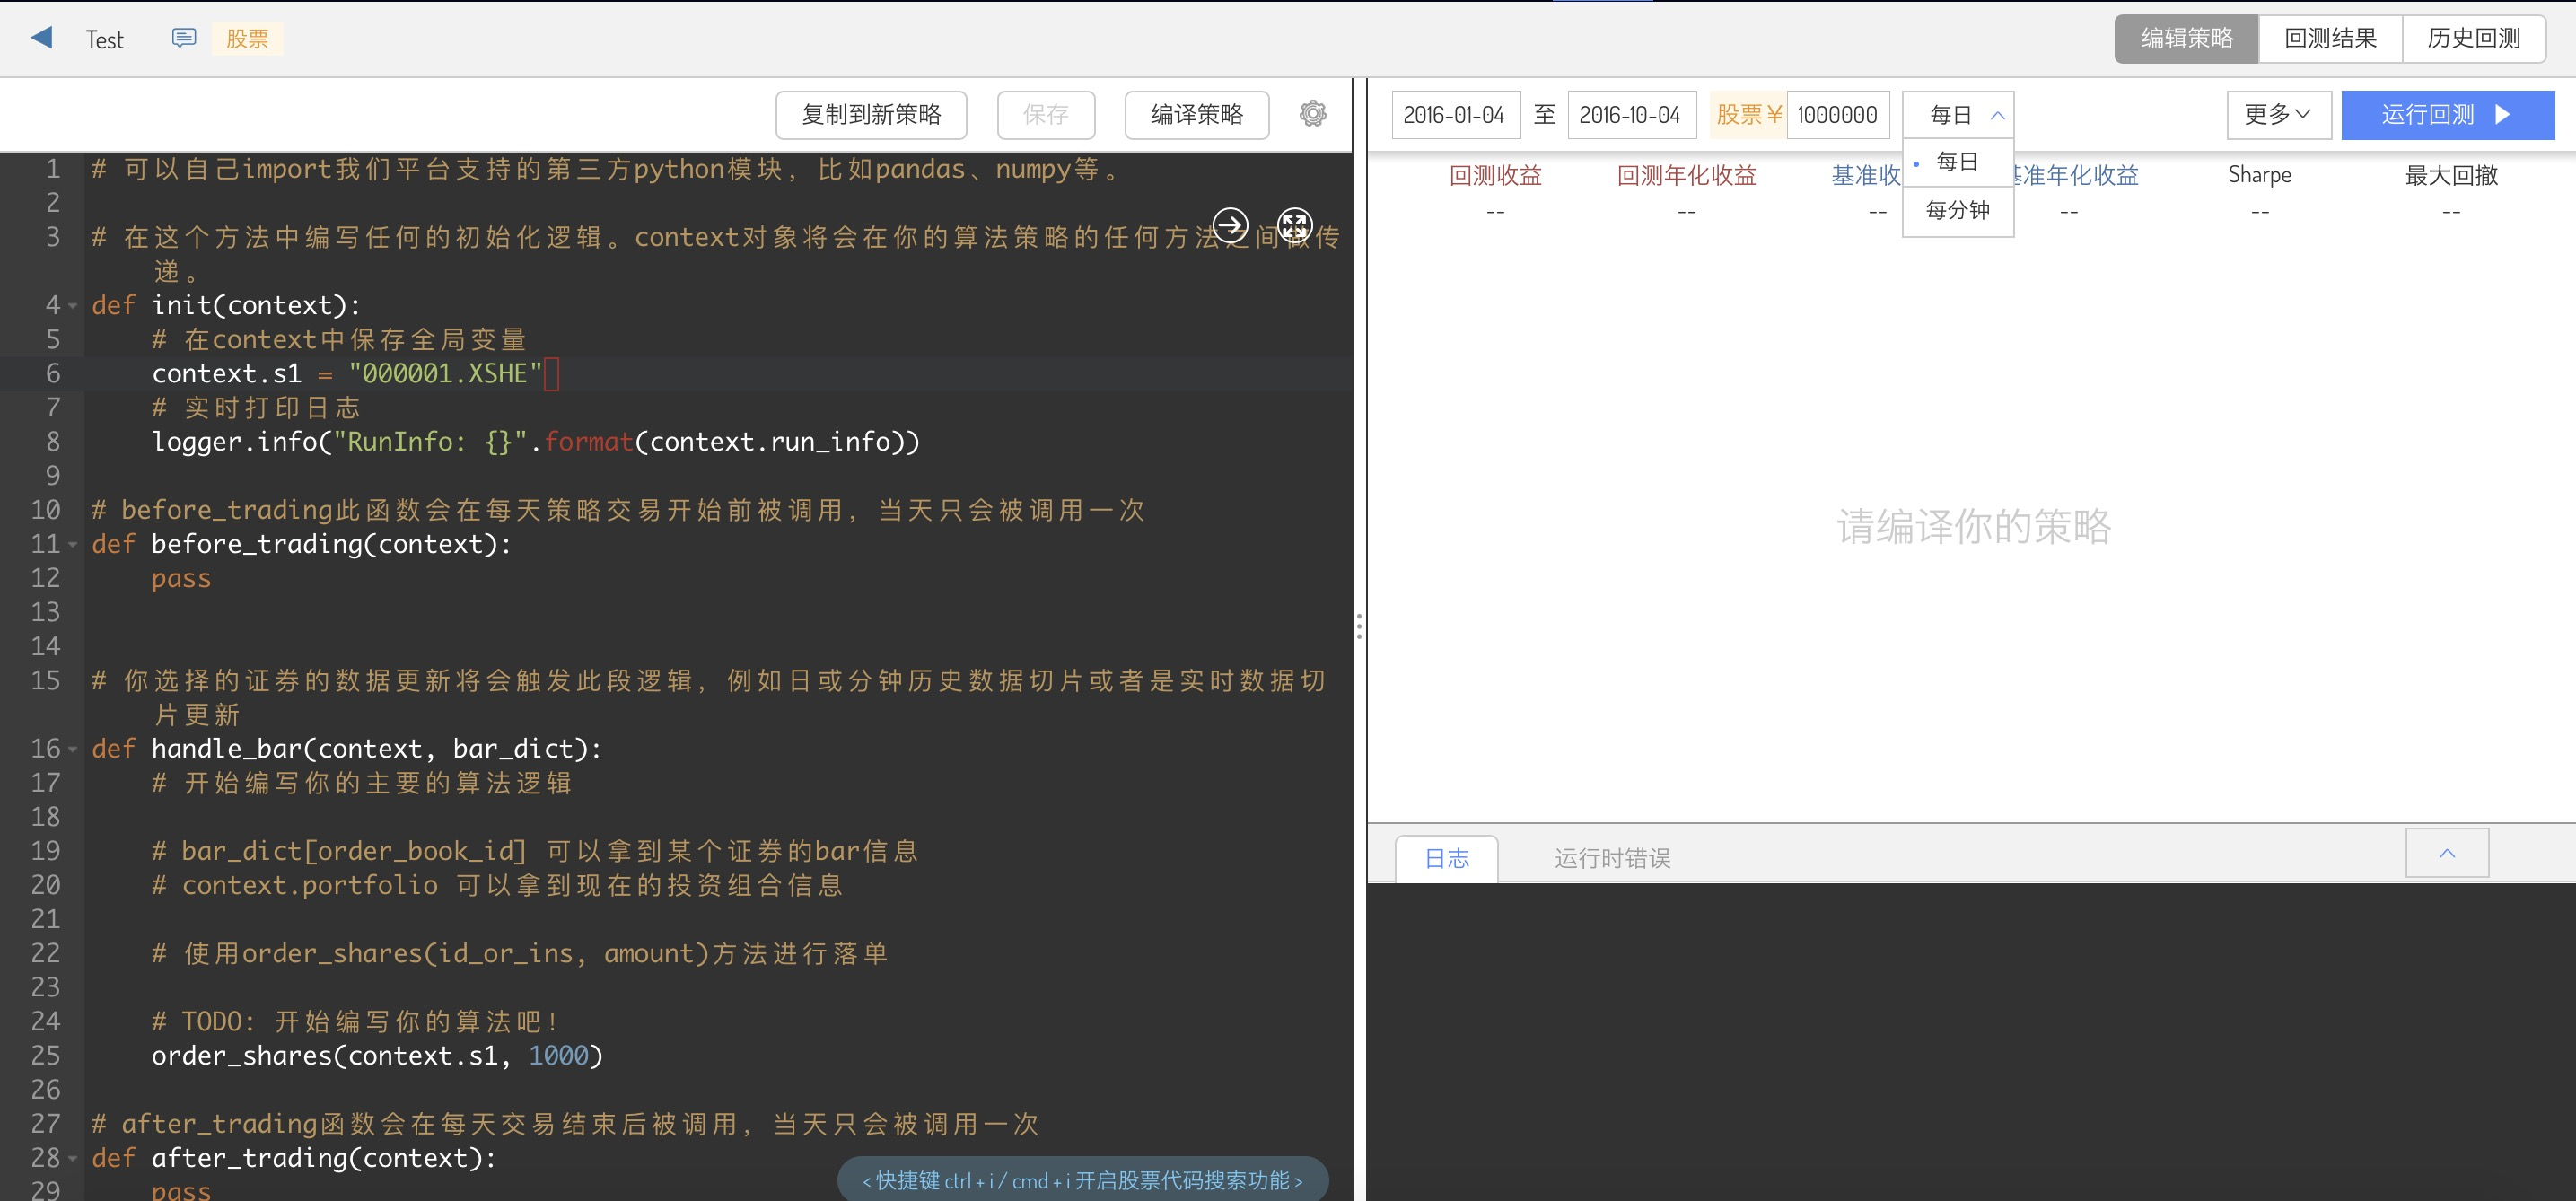

In [1]:
from IPython.display import display, Image
display(Image(filename='minute_or_day.jpeg'))

介绍scheduler，引入更低频的策略
---
有时我们虽然使用日频回测，但是并不希望每天都运行代码的全部，正如在分钟级别回测时，我们很可能希望每天只更新（计算）一次股票池，而不是每一分钟都运行一次更新股票池的程序，这会大大增加回测的时间成本。这时，scheduler函数为我们提供了一份解决方案。

注： scheduler函数只能在init中运行。

In [ ]:
# 定义一个更新股票池的函数
def update_universe(context,bar_dict): # 该函数必须且仅能包含context和bar_dict两个输入参数
    # 选出当日沪深300成分股，并传给context
    context.stock_list = index_components('沪深300')
    pass

# 每天运行
scheduler.run_daily(update_universe)

# 每周运行
# 定时在每周x运行
scheduler.run_weekly(update_universe,weekday=x)
# 定时在每周第t个交易日运行
scheduler.run_weekly(update_universe,tradingday=t)

# 每月运行
# 定时在每月第t个交易日运行
scheduler.run_monthly(update_universe,tradingday=t)

在分钟级别回测中，我们还可以使用time_ruler 更精确的使用定时器scheduler

In [ ]:
# 每日的开市后20分钟运行：
scheduler.run_daily(function, time_rule=market_open(minute=20)) #注：如果不设置time_rule 默认开市后一分钟运行

# 每周的第t个交易日闭市前1小时运行：
scheduler.run_weekly(function, tradingday=t, time_rule=market_close(hour=1))

# 每天开始交易前运行：
scheduler.run_daily(function, time_rule='before_trading')

介绍context里面的成员，以及相关的设置
---

context 是一组全局变量，用于在init，before_trading，handle_bar，after_trading间传递参数。
我们提供了6个context函数分别是:
* context.now —— handle_bar中当前bar的时间
* context.portfolio —— 投资组合信息
* context.stock_portfolio —— 股票投资组合信息
* context.future_portfolio —— 期货投资组合信息
* context.run_info —— 策略运行信息
* context.universe —— 策略合约池

In [ ]:
# 当前bar时间
context.now

# 投资组合信息 —— 以positions为例
context.portfolio.positions # 返回一个dict

# 股票投资组合信息 —— 以投资组合至今累积收益率为例
context.stock_portfolio.total_returns

# 期货投资组合信息 —— 以当日盈亏为例
context.future_portfolio.daily_pnl

# 策略运行信息 —— 以benchmark为例
context.run_info.benchmark

# 策略合约池
context.universe
# 更新策略合约池
update_universe

同时，context也可用于用户自定义的参数传递。
自定义的context变量需要先在init函数中申明。

In [ ]:
# 自定义选股股票池为当日沪深300成分股
context.stock_list = index_components('沪深300')

下单管理
---

ricequant 为用户提供多样的下单方式。

#### 股票

* order_shares —— 指定股数交易
* order_lots —— 指定手数交易
* order_value —— 指定价值交易
* order_percent —— 指定比例下单
* order_target_value —— 目标价值下单
* order_target_percent —— 目标比例下单

#### 期货

* buy_open —— 买开
* sell_close —— 平多仓
* sell_open —— 卖开
* buy_close —— 买开
* cancel_order —— 撤单
* get_open_orders —— 拿到未成交订单信息
